In [1]:
# This code works in Python 3.10.6
import os
import torch
import dgl
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
import numpy as np
import pandas as pd
import networkx as nx
import random
import glob
from collections import Counter
import torch_geometric.utils.convert
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(1, '../../../../../../evaluation/')
sys.path.insert(1, '../../../../../../evaluation/model/')
sys.path.insert(1, '../../../../../../evaluation/postprocessing/')
sys.path.insert(1, '../../../../../../evaluation/select_explanation/')

In [3]:
import plots
import utils
import imdb_model as GNN
import imdb_postprocessing as postprocessing
import imdb_select_explanation as select_explanation

In [7]:
feature_size=3066
RUNS = 10

Create Metagraph

In [3]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

Extracting imdb_data/raw/IMDB_processed.zip
Processing...


HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


Done!


In [4]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

In [5]:
dataset = dataset = IMDB(root='./imdb_data')
data = dataset[0]
data

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

Train IMDB

In [10]:
#List of edges in metagraph of IMDB
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [5]:
graphs_path = '../../../../../../graph generator/baseline_vae/sampled_graphs_vae/'
print('Original no of graphs:',len([name for name in glob.glob(graphs_path + 'imdb/*')]))

Original no of graphs: 1536


In [15]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [17]:
for i in range(0,RUNS):   
    counter = i
    model = GNN.HAN(data.metadata(), in_channels=-1, out_channels=3)
    
    device = 'cpu'
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 700):  
        loss = GNN.train(data,model,optimizer)
        train_acc, val_acc, test_acc = GNN.test(data,model)
        # if epoch%200==0:
        #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
        #           f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            # print('Stopping training as validation accuracy did not improve '
            #       f'for {start_patience} epochs')
            break
    
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}
    rootdir = graphs_path + 'imdb/'
    
    dir_list = []
    for subdir, dirs,files in os.walk(rootdir):
        
        if files:
            graph_path = os.path.join(subdir, files[0])
            class_path = os.path.join(subdir, files[1])       
            feature_path = os.path.join(subdir, files[2])
            
            graph = nx.read_gexf(graph_path)
            filename = os.path.basename(graph_path)
            graph_id= filename.split('.')[0]
            #print(graph_id)
            
            nodeId_list = []
            
            for key, value in graph.nodes(data=True):
                nodeId_list.append(key)
                edges = [e for e in graph.edges]
                
            node_type_list = torch.load(class_path).detach().numpy()
            
            df_graph = pd.DataFrame()
            df_graph["nodeId"] = nodeId_list
            df_graph["class"] = node_type_list
            
            
            df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy()).iloc[:, : feature_size]       
            df_feature["class"] = node_type_list
                              
            movie_node_features = utils.convert_to_discrete(df_feature[df_feature['class'] == 2].drop(['class'], axis = 1))
               
            labels = []
            unique_labels = [0,1,2]
    
            for i in range(0,len(movie_node_features)):
                labels.append(random.choice(unique_labels))
                
            movie_node_features['class']= labels
    
            director_node_features = df_feature[df_feature['class'] == 0].drop(['class'], axis = 1)
            actor_node_features = df_feature[df_feature['class'] == 1].drop(['class'], axis = 1)
    
    
            small_graph_data, removed_edges, graph_edges = postprocessing.create_dataset(nodeId_list,edges,
                                    movie_node_features,director_node_features,
                                    actor_node_features,graph_id,df_graph)
        
            all_edges.update(graph_edges)
            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):
                
                    
                if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) :

                    softmax = select_explanation.evaluate_gnn(small_graph_data,model)
                    softmax_dict[graph_id] = softmax
                    nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x,
                                            'director':small_graph_data['director'].x,
                                            'actor':small_graph_data['actor'].x}
                    graph_dict[graph_id]=df_graph
    
    print("No. of graphs evaluated: ",len(softmax_dict))

    avg_max_pred, max_pred, class_graphid = select_explanation.get_max_pred(softmax_dict,counter)
    
    avg_max_pred_list.append(avg_max_pred)
    max_pred_list.append(max_pred)
    graph_dict_list.append(graph_dict)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    all_edges_list.append(all_edges)
    class_graphid_list.append(class_graphid)

No. of graphs evaluated:  513
Run0 0.9992101192474365 0.9999947547912598 0.9999794960021973
No. of graphs evaluated:  513
Run1 0.9942512512207031 0.9999909400939941 0.9999890327453613
No. of graphs evaluated:  513
Run2 0.9991223216056824 0.9999933242797852 0.9999716281890869
No. of graphs evaluated:  513
Run3 0.9996520280838013 0.9999995231628418 0.999998927116394
No. of graphs evaluated:  513
Run4 0.9983830451965332 0.9999945163726807 0.9999557733535767
No. of graphs evaluated:  513
Run5 0.9994096755981445 0.9999996423721313 0.9999796152114868
No. of graphs evaluated:  513
Run6 0.99882572889328 0.9999996423721313 0.9999901056289673
No. of graphs evaluated:  513
Run7 0.9997541308403015 0.9999963045120239 0.9999648332595825
No. of graphs evaluated:  513
Run8 0.9972526431083679 0.9999943971633911 0.9999630451202393
No. of graphs evaluated:  513
Run9 0.9996193647384644 0.9999959468841553 0.9999948740005493


In [18]:
avg_max_pred_list

[0.9997281233469645,
 0.9980770746866862,
 0.9996957580248514,
 0.9998834927876791,
 0.9994444449742635,
 0.9997963110605875,
 0.9996051589647929,
 0.9999050895373026,
 0.9990700284639994,
 0.9998700618743896]

In [19]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.9995075543721516


In [20]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.0005338012556257288


In [21]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

7

In [26]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]

In [27]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]

In [28]:
all_edges = all_edges_list[index]

In [29]:
graph_dict = graph_dict_list[index]

In [30]:
softmax_dict = softmax_dict_list[index]

In [31]:
nodefeature_dict = nodefeature_dict_list[index]

In [32]:
nodefeature_dict = nodefeature_dict_list[index]

 Plotting explanation graphs and node features for each class of Movie node
 
 Node colors:
 
 Director - Blue
 
 Actor - Red
 
 Movie - Darkgreen

Number of nodes:  7
graph id:  sync342900120350_G7
Max pred probability for class 0 is 0.9997541308403015


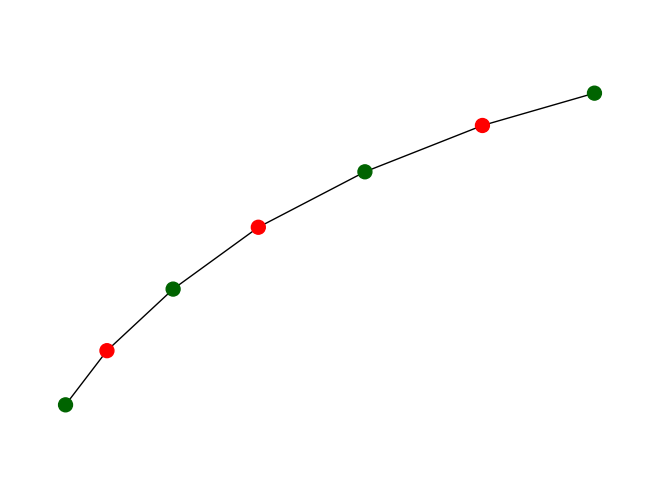

In [33]:
explanation_graph0 = plots.plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [34]:
ind= utils.index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].cpu().numpy()[ind]
Counter(list0)

Counter({0.0: 3066})

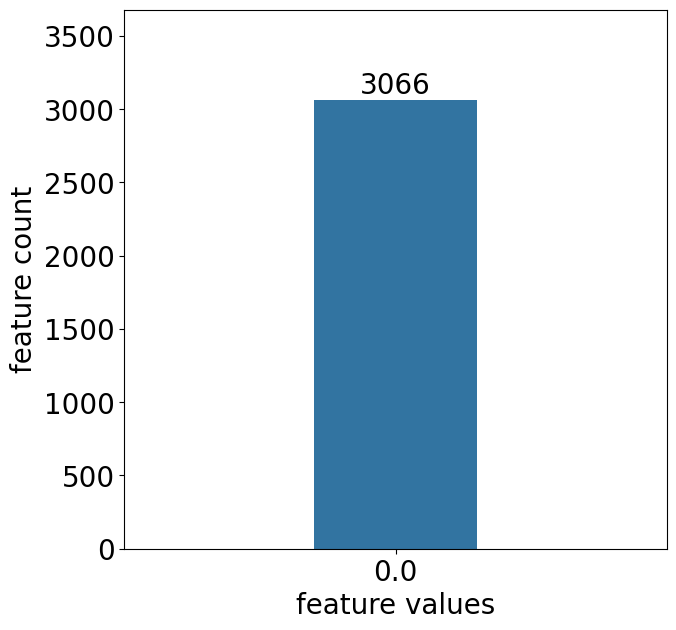

In [35]:
plots.count_plot(list0)

Number of nodes:  4
graph id:  sync640613115712_G6
Max pred probability for class 1 is 0.9999963045120239


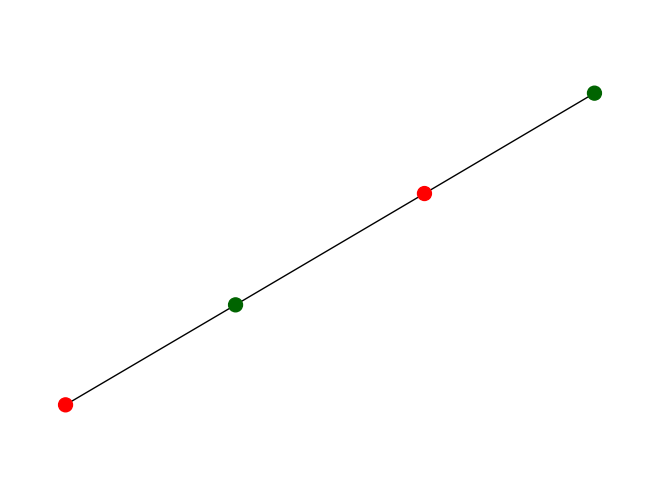

In [36]:
explanation_graph1 = plots.plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [37]:
ind= utils.index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].cpu().numpy()[ind]
Counter(list1)

Counter({0.0: 3066})

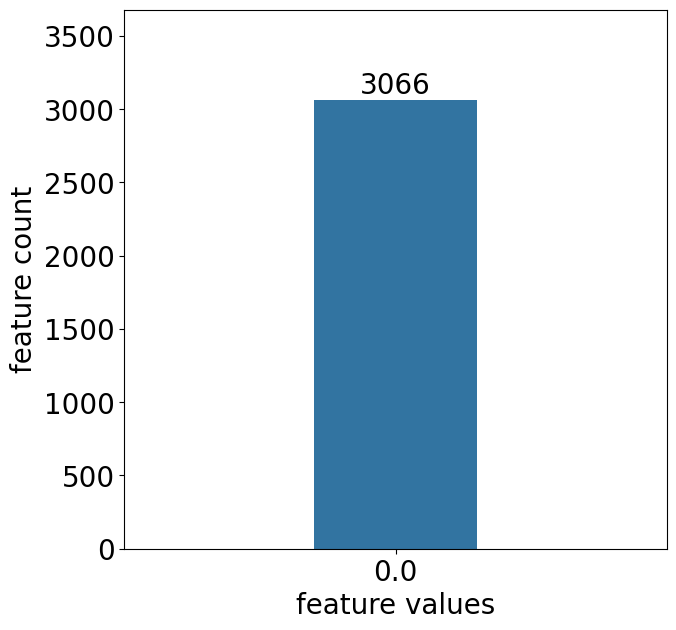

In [38]:
plots.count_plot(list1)

Number of nodes:  5
graph id:  sync138549114536_G10
Max pred probability for class 2 is 0.9999648332595825


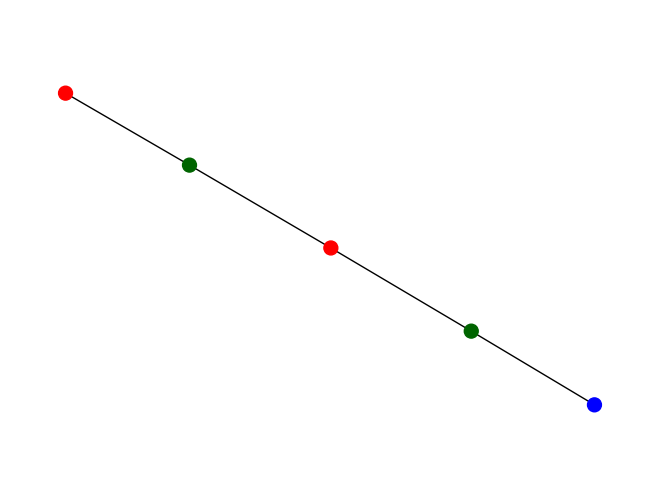

In [39]:
explanation_graph2 = plots.plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [40]:
ind= utils.index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].cpu().numpy()[ind]
Counter(list2)

Counter({0.0: 3066})

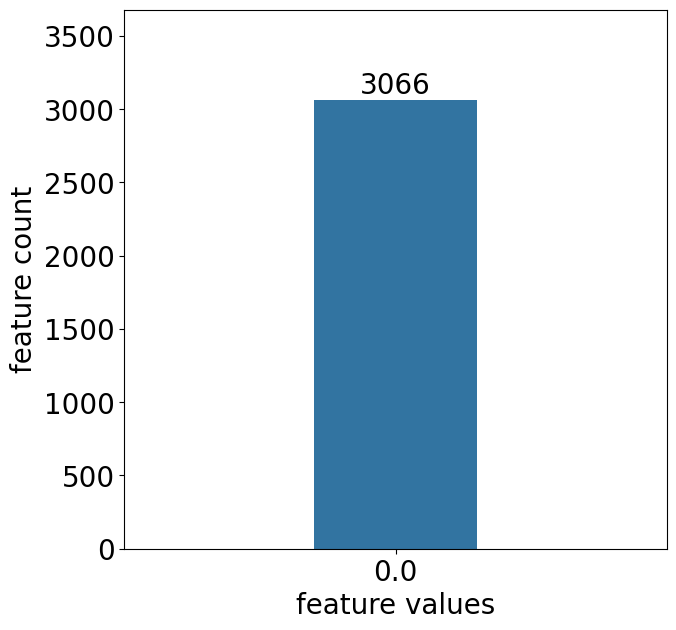

In [41]:
plots.count_plot(list2)

In [44]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].cpu().numpy())
utils.print_stat_cont_features(actor0_df)

mean -0.0025443458
std dev 0.14117374


Text(0, 0.5, 'Density')

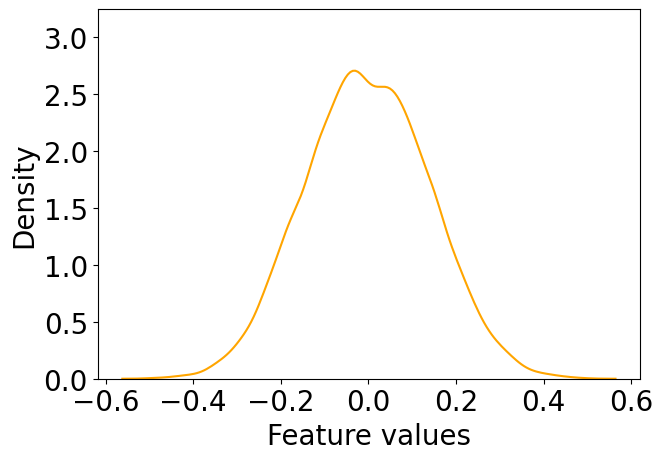

In [45]:
plots.plot_cont_feat(actor0_df)

In [46]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].cpu().numpy())
utils.print_stat_cont_features(actor1_df)

mean -0.0013146095
std dev 0.15332566


Text(0, 0.5, 'Density')

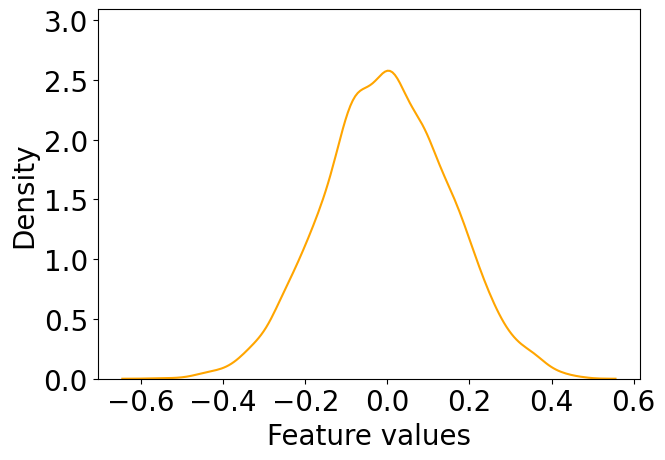

In [47]:
plots.plot_cont_feat(actor1_df)

In [48]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].cpu().numpy())
utils.print_stat_cont_features(actor2_df)

mean -0.0014828285
std dev 0.11157271


Text(0, 0.5, 'Density')

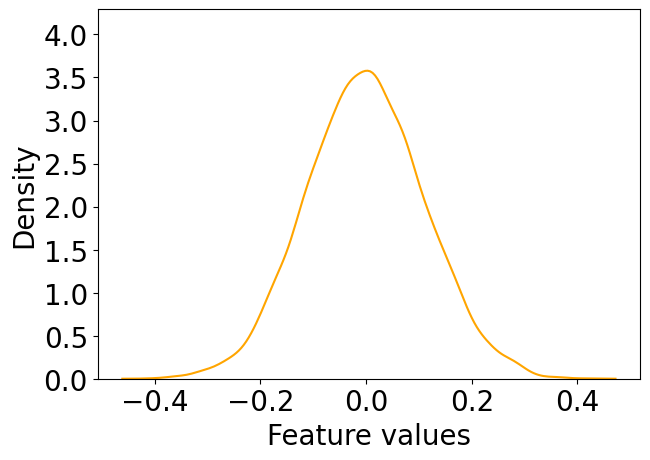

In [49]:
plots.plot_cont_feat(actor2_df)

In [6]:
motifs_path = '../../../../../motifs/imdb/'

In [7]:
from os import walk
w = walk(motifs_path)

for (dirpath, dirnames, filenames) in w:
    print(dirpath,filenames)
    

../../../../../motifs/imdb/ []
../../../../../motifs/imdb/class0 ['motif_real_imdb_15.gexf', 'motif_real_imdb_16.gexf', 'motif_real_imdb_17.gexf', 'motif_real_imdb_23.gexf', 'motif_real_imdb_24.gexf', 'motif_real_imdb_25.gexf', 'motif_real_imdb_26.gexf', 'motif_real_imdb_36.gexf', 'motif_real_imdb_6.gexf', 'motif_real_imdb_7.gexf']
../../../../../motifs/imdb/class1 ['motif_real_imdb_0.gexf', 'motif_real_imdb_1.gexf', 'motif_real_imdb_11.gexf', 'motif_real_imdb_20.gexf', 'motif_real_imdb_21.gexf', 'motif_real_imdb_32.gexf', 'motif_real_imdb_35.gexf', 'motif_real_imdb_38.gexf', 'motif_real_imdb_39.gexf', 'motif_real_imdb_9.gexf']
../../../../../motifs/imdb/class2 ['motif_real_imdb_10.gexf', 'motif_real_imdb_13.gexf', 'motif_real_imdb_14.gexf', 'motif_real_imdb_2.gexf', 'motif_real_imdb_22.gexf', 'motif_real_imdb_27.gexf', 'motif_real_imdb_30.gexf', 'motif_real_imdb_33.gexf', 'motif_real_imdb_4.gexf', 'motif_real_imdb_8.gexf']


In [53]:
faithfulness_list = []

for i in range(0,RUNS):
    faithfulness = utils.get_faithfulness(class_graphid_list[i],all_edges_list[i],motifs_path)

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.2333333333333333
Run1 0.6666666666666666
Run2 0.43333333333333335
Run3 0.5333333333333333
Run4 0.43333333333333335
Run5 0.13333333333333333
Run6 0.2333333333333333
Run7 0.4333333333333333
Run8 0.3666666666666667
Run9 0.13333333333333333
Mean 0.36


In [54]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.16586473739499638
